In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random, os, math, itertools, time, pickle
from datetime import datetime
from joblib import Parallel, delayed
from networkx.utils import py_random_state
from networkx.algorithms import community
from scipy.optimize import fsolve, minimize

In [3]:
# Compute the homophily associated with a clique of size c with i red nodes.
def h_min(c, nr):
    nb = 1 - nr
    return ((c - 2) / (2 * c - 2) - nr**2 - nb**2) / (1 - nr**2 - nb**2)


def clique_h_index(c, i, frac_red):
    """
    Compute the Coleman homophily index of a clique.

    Parameters:
    c (int): Number of nodes in the clique
    i (int): Number of red nodes in the clique
    frac_red (float): Fraction of red nodes globally

    Returns:
    float: Coleman homophily index of clique type-i (variant)
    """
    expin = frac_red**2 + (1 - frac_red)**2
    in_group = (math.comb(i, 2) + math.comb(c - i, 2)) / math.comb(c, 2)
    return (in_group - expin) / (1 - expin)

# Compute the maximum entropy clique distribution
def F_maximum_entropy(c, h, frac_red):
    """
    Compute the clique probability distribution vector F = [F_0,...,F_c].

    Parameters:
    c (int): Clique size
    h (float): Local homophily we want
    frac_red (float): Fraction of red nodes globally

    Returns:
    list: Clique probability distribution vector
    """
    def objective(vars):
        lam, theta = vars
        Z = sum([math.exp(theta * clique_h_index(c, i, frac_red) + i * lam) for i in range(c + 1)])
        F = [math.exp(theta * clique_h_index(c, i, frac_red) + i * lam) / Z for i in range(c + 1)]

        f1 = sum([i * F[i] for i in range(c + 1)]) - c * frac_red
        f2 = sum([clique_h_index(c, i, frac_red) * F[i] for i in range(c + 1)]) - h
        return f1**2 + f2**2

    initial_guess = [0., 0.]
    result = minimize(objective, initial_guess, bounds=[(-10, 10), (-10, 10)], tol=1e-9)

    lam_sol, theta_sol = result.x

    F = [math.exp(theta_sol * clique_h_index(c, i, frac_red) + i * lam_sol) for i in range(c + 1)]
    Z = sum(F)
    F = [Fi / Z for Fi in F]

    return F

def elgent_graphs(N, Nr, h2, h, ave_degree, alpha = 0.5, c = 6, c2 = 2):
    if h < h_min(c, Nr/N) or h2 < h_min(c2, Nr/N):
        raise ValueError("this configuration is impossible")           
    M = int(ave_degree * N / ((1-alpha)*(c2 * (c2 - 1))+(alpha*c * (c - 1))))

    F = F_maximum_entropy(c, h, Nr/N) 
    if len(F) != c + 1:
        raise ValueError("F must have a length of c + 1")
    else:
        F = np.array(F, dtype=float)
        F /= np.sum(F)

    G = nx.Graph()
    G.add_nodes_from(range(N))

    # Randomly choose red nodes
    red_nodes = np.random.choice(N, size=Nr, replace=False)
    blue_nodes = np.setdiff1d(np.arange(N), red_nodes)

    red_nodes_set = set(red_nodes)
    blue_nodes_set = set(blue_nodes)

    for node in G.nodes:
        G.nodes[node]['color'] = 'red' if node in red_nodes_set else 'blue'

    # Sample cliques according to F
    chosen_nodes = []
    for _ in range(int(alpha*M)):
        # Determine the type of clique based on F
        clique_type = np.random.choice(c + 1, p=F)
        
        # Sample nodes for the clique
        red_sample = np.random.choice(red_nodes, clique_type, replace=False)
        blue_sample = np.random.choice(blue_nodes, c - clique_type, replace=False)
        clique_nodes = np.concatenate((red_sample, blue_sample))
        chosen_nodes.append(clique_nodes)
    
    # Generate edges
    edges = []
    for sublist in chosen_nodes:
        edges.extend(itertools.combinations(sublist, 2))
    G.add_edges_from(edges)
    #E1 = len(edges)

    F = F_maximum_entropy(c2, h2, Nr/N)
    chosen_nodes = []
    for _ in range(int((1-alpha)*M)):
        clique_type = np.random.choice(c2 + 1, p=F)
        red_sample = np.random.choice(red_nodes, clique_type, replace=False)
        blue_sample = np.random.choice(blue_nodes, c2 - clique_type, replace=False)
        clique_nodes = np.concatenate((red_sample, blue_sample))
        chosen_nodes.append(clique_nodes)
    
    # Generate edges
    edges2 = []
    for sublist in chosen_nodes:
        edges2.extend(itertools.combinations(sublist, 2))
    G.add_edges_from(edges2)
    #E2 = len(edges2)

    G.remove_edges_from(nx.selfloop_edges(G))

    # Print statistics
    #print('Assortativity: ', calculate_assortativity(G))
    print('Total Homophily: ', homophily(alpha, c, h, c2, h2))

    #red_degrees = [d for n, d in G.degree() if G.nodes[n]['color'] == 'red']
   # blue_degrees = [d for n, d in G.degree() if G.nodes[n]['color'] == 'blue']
    #degrees = [d for n, d in G.degree()]
    #mean_degree = np.mean(degrees)
    #std_degree = np.std(degrees)
    
    #print('Size of the GC: ', gc_size(G))
    #print('Mean Degree: ', mean_degree, '±', std_degree)
    #print('Red nodes average degree: ', np.mean(red_degrees))
    #print('Blue nodes average degree: ', np.mean(blue_degrees))
    #if alpha == alpha_star(c):
        #print(E1, E2)
    return G

    #homophily = lambda h, h2, E1, E2: (E2*h2 + E1*h)/(E2 + E1)
def homophily(alpha, c, h, c2, h2):
    numerator = alpha * c * (c - 1) * h + (1 - alpha) * c2 * (c2 - 1) * h2
    denominator = alpha * c * (c - 1) + (1 - alpha) * c2 * (c2 - 1)
    return numerator / denominator
    
def plot_network_and_degree_distribution(G):
    # Calculate positions and colors for nodes
    pos = nx.kamada_kawai_layout(G)
    colors = [G.nodes[n]['color'] for n in G.nodes]
    color_map = {'red': 'coral', 'blue': 'teal'}
    node_colors = [color_map[color] for color in colors]
    
    # Separate degrees by node color
    red_degrees = [d for n, d in G.degree() if G.nodes[n]['color'] == 'red']
    blue_degrees = [d for n, d in G.degree() if G.nodes[n]['color'] == 'blue']
    degrees = [d for n, d in G.degree()]
    assortativity = calculate_assortativity(G)

    # Normalize degree distributions
    total_counts, total_bins = np.histogram(degrees, bins=range(min(degrees), max(degrees) + 2))
    red_counts, red_bins = np.histogram(red_degrees, bins=range(min(red_degrees), max(red_degrees) + 2))
    blue_counts, blue_bins = np.histogram(blue_degrees, bins=range(min(blue_degrees), max(blue_degrees) + 2))

    # Create figs directory if it does not exist
    if not os.path.exists('figs'):
        os.makedirs('figs')
        
    # Create a figure with the network on the left and combined degree distributions on the right
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Plot the network
    nx.draw(G, pos, node_color=node_colors, node_size=50, with_labels=False, ax=ax1)
    ax1.set_title(f"The Elegant Network with Assortativity: {assortativity:.2f}", fontsize=16)
    
    # Plot the combined degree distributions
    ax2.bar(total_bins[:-1], total_counts, width=1, edgecolor='black', alpha=1, color='white', label='Total')
    ax2.bar(red_bins[:-1], red_counts, width=1, edgecolor='black', alpha=0.7, color='coral', label='Red Nodes')
    ax2.bar(blue_bins[:-1], blue_counts, width=1, edgecolor='black', alpha=0.7, color='teal', label='Blue Nodes')

    ax2.set_title("Degree Distribution", fontsize=16)
    ax2.set_xlabel("Degree", fontsize=14)
    ax2.set_ylabel("Normalized Frequency", fontsize=14)
    ax2.legend(fontsize=12)
    
    # Adjust layout to fit contents tightly
    plt.tight_layout()
    fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    
    
    # Save the figure
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = os.path.join('figs', f'network_and_degree_distribution_{timestamp}.pdf')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

def number_cliques(G):
    return len(nx.find_cliques(G))

def calculate_assortativity(G):
    return nx.attribute_assortativity_coefficient(G, 'color')

def make_graph(g, p):
    edgelist = list(g.edges())
    L = len(edgelist)
    new_g = nx.Graph()
    new_g.add_nodes_from(g.nodes())
    new_g.add_edges_from(random.sample(edgelist, int(p * L)))
    return new_g

def gc_size(g):
    largest_cc = max(nx.connected_components(g), key=len)
    return len(largest_cc) / g.number_of_nodes()

def components(g):
    return list(nx.connected_components(g))

def susceptibility(components):
    sizes = [len(component) for component in components]
    giant_size = max(sizes)
    sizes.remove(giant_size)
    if sizes:
        return np.mean(sizes)
    else:
        return 0

def percolation(g, p_range, ens=10):
    def Gs(g, p_range):
        return [gc_size(make_graph(g, p)) for p in p_range]

    gcc = Parallel(n_jobs=-1)(delayed(Gs)(g, p_range) for _ in range(ens))
    gcc = np.array(gcc)
    return np.mean(gcc, axis=0), np.std(gcc, axis=0)

def sus(g, p_range, ens=10):
    def Ss(g, p_range):
        S = np.array([susceptibility(components(make_graph(g, p))) for p in p_range])
        S /= np.max(S) if np.max(S) != 0 else 1
        return S

    scc = Parallel(n_jobs=-1)(delayed(Ss)(g, p_range) for _ in range(ens))
    scc = np.array(scc)
    return np.mean(scc, axis=0)

def total_number_of_triangles(G):
    triangles_per_node = nx.triangles(G)
    total_triangles = sum(triangles_per_node.values()) // 3
    return total_triangles

def plot_results(p_range, mean_gcc, std_gcc, mean_sus):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('p')
    ax1.set_ylabel('GC')
    ax1.plot(p_range, mean_gcc, 'k-', label='Giant Component Size')
    ax1.fill_between(p_range, mean_gcc - std_gcc, mean_gcc + std_gcc, color='black', alpha=0.2)
    ax1.plot(p_range, mean_sus, 'k--', label='Normalized Susceptibility')

    ax1.legend(loc='best')
    plt.title('Giant Component Size and Normalized Susceptibility')
    plt.tight_layout()

    # Create figs directory if it does not exist
    if not os.path.exists('figs'):
        os.makedirs('figs')

    # Generate a unique filename with timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = os.path.join('figs', f'percolation_{timestamp}.pdf')

    # Save the figure
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
def plot_network(G):
    # Calculate positions and colors for nodes
    pos = nx.kamada_kawai_layout(G)
    colors = [G.nodes[n]['color'] for n in G.nodes]
    color_map = {'red': 'coral', 'blue': 'teal'}
    node_colors = [color_map[color] for color in colors]

    assortativity = calculate_assortativity(G)
    
    # Create figs directory if it does not exist
    if not os.path.exists('figs'):
        os.makedirs('figs')
        
    # Create a figure for the network
    fig = plt.figure(figsize=(12, 12))
    
    # Plot the network
    nx.draw(G, pos, node_color=node_colors, node_size=50, with_labels=False)
    
    # Add title to the left of the figure with a larger font size
    #fig.suptitle(f"The Elegant Network with Assortativity: {assortativity:.2f}", fontsize=24, x=0.05, ha='left')
    
    # Save the figure
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = os.path.join('figs', f'network_{timestamp}.pdf')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

def alpha_star(c, c2=2):
    numerator = c2 * (c2 - 1)
    denominator = c2 * (c2 - 1) + c * (c - 1)
    return numerator / denominator

Total Homophily:  0.9

	Elapsed time: 0.01 minutes


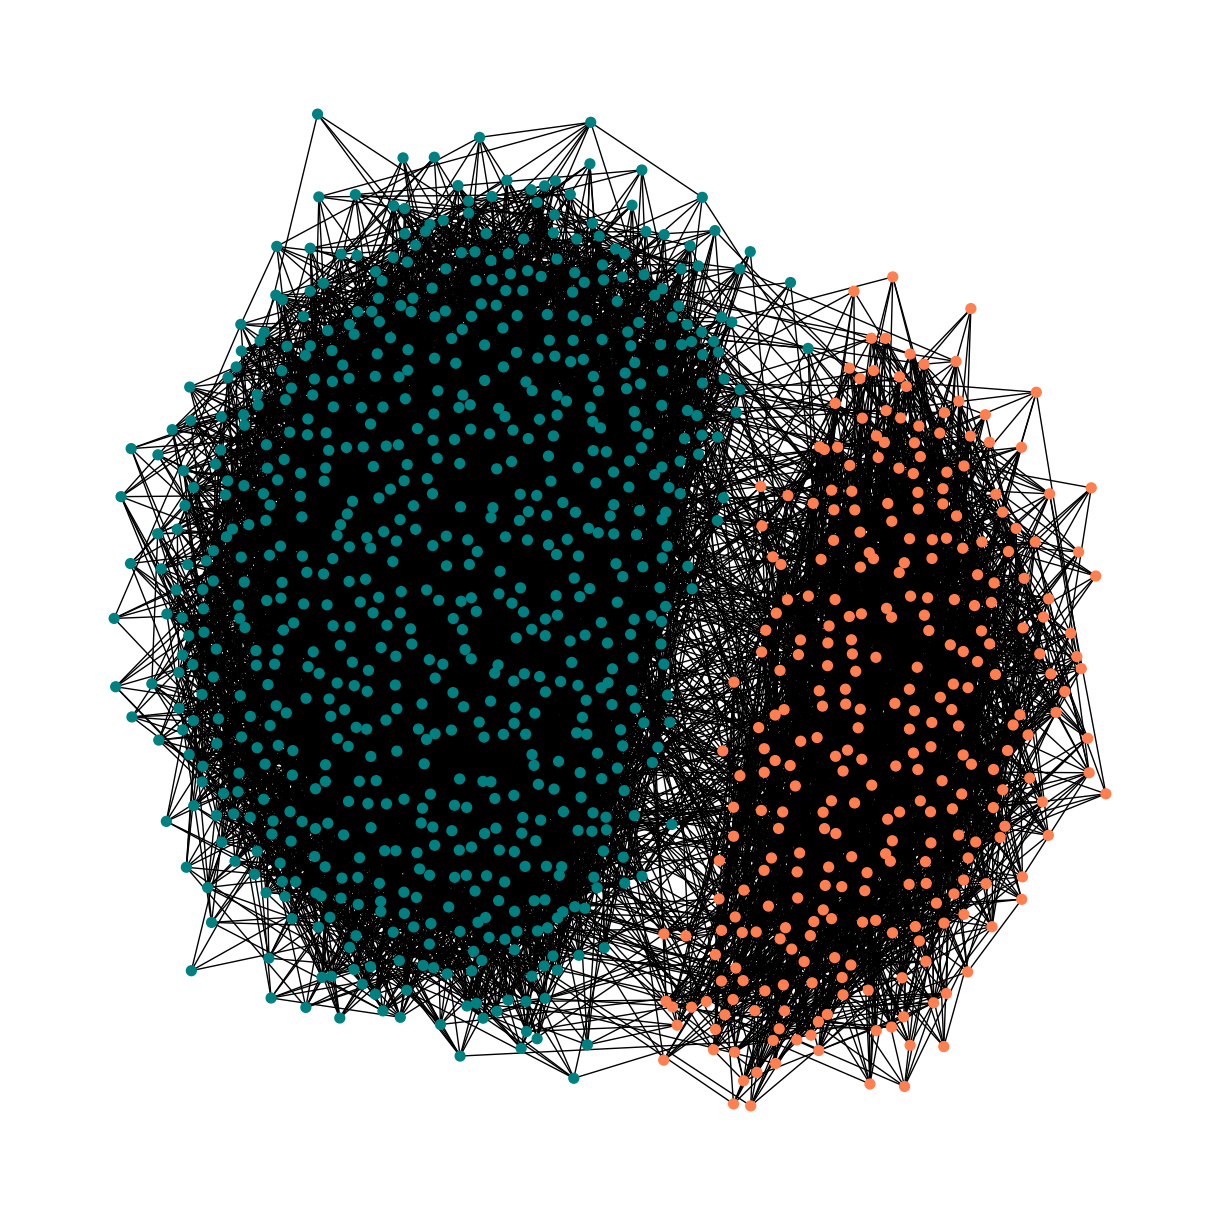

In [5]:
start_time = time.time()

N = 10**3
Nr = int(0.3*N)
h2 = .9 #for c =2
h = .9 # for c > 2
ave_degree = 20
g = elgent_graphs(N, Nr, h2, h, ave_degree, alpha = alpha_star(c=6))

print(f"\n\tElapsed time: {(time.time() - start_time)/60:.2f} minutes")
plot_network(g)

# Percolation 

In [4]:
def label_links(g):
    edge_labels = {}
    for u, v in g.edges():
        if g.nodes[u]['color'] == 'red' and g.nodes[v]['color'] == 'red':
            edge_labels[(u, v)] = 'rr'
        elif g.nodes[u]['color'] == 'blue' and g.nodes[v]['color'] == 'blue':
            edge_labels[(u, v)] = 'bb'
        else:
            edge_labels[(u, v)] = 'rb'
    return edge_labels

def make_color_graph(g, Pi):
    edge_labels = label_links(g)
    rr_edges = [e for e in edge_labels if edge_labels[e] == 'rr']
    rb_edges = [e for e in edge_labels if edge_labels[e] == 'rb']
    bb_edges = [e for e in edge_labels if edge_labels[e] == 'bb']

    new_g = nx.Graph()
    new_g.add_nodes_from(g.nodes())

    sampled_rr_edges = random.sample(rr_edges, int(Pi[0] * len(rr_edges)))
    sampled_rb_edges = random.sample(rb_edges, int(Pi[1] * len(rb_edges)))
    sampled_bb_edges = random.sample(bb_edges, int(Pi[2] * len(bb_edges)))

    new_g.add_edges_from(sampled_rr_edges + sampled_rb_edges + sampled_bb_edges)
    return new_g


def color_percolation(g, Pi_range, ens=10):
    def Gs(g, Pi_range):
        return [gc_size(make_color_graph(g, Pi)) for Pi in Pi_range]

    gcc = Parallel(n_jobs=-1)(delayed(Gs)(g, Pi_range) for _ in range(ens))
    gcc = np.array(gcc)
    return np.mean(gcc, axis=0), np.std(gcc, axis=0)

def sus(g, Pi_range, ens=10):
    def Ss(g, Pi_range):
        S = np.array([susceptibility(components(make_color_graph(g, Pi))) for Pi in Pi_range])
        S /= np.max(S) if np.max(S) != 0 else 1
        return S

    scc = Parallel(n_jobs=-1)(delayed(Ss)(g, Pi_range) for _ in range(ens))
    scc = np.array(scc)
    return np.mean(scc, axis=0)

In [ ]:
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print(timestamp)

N = 10**6
ave_degree = 6
Nr = int(.6*N)
combinations = [(-0.3, 0.3), (-0.3, 0.9), (0.0, 0.0), (0.0, 0.6), (0.6, 0.0), (0.6, 0.6)]
p_range = np.linspace(0, 1, 70)
p_rb, p_bb = 0.2, 0
Pi_range = [[p_rr, p_rb, p_bb] for p_rr in p_range]
ens = 250

# Initialize the plot with larger font sizes
plt.figure(figsize=(10, 8))
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

# Color and linestyle arrays
colors = ['y', 'c', 'b', 'g', 'r', 'm']  # Yellow, Cyan, Blue, Green, Red, Magenta
linestyles = ['-.', ':', '-', '--', '-.', ':']  # Dot-dash, Dotted, Solid, Dashed, Dot-dash, Dotted
markers = ['o', 's', 'D', 'P', '^', 'v']  # Circle, Square, Diamond, Plus, Triangle, Inverted Triangle

# Loop over each combination of c and h
Data = []
for idx, (h2, h) in enumerate(combinations):
    G = elgent_graphs(N, Nr, h2, h, ave_degree, alpha=alpha_star(c=6))
    mean_gcc, std_gcc = color_percolation(G, Pi_range, ens)
    mean_sus = sus(G, Pi_range, ens)

    Data.append([G, mean_gcc, std_gcc, mean_sus])

    # Plot giant component size with unique color, linestyle, and marker
    plt.plot(p_range, mean_gcc, color=colors[idx], linestyle=linestyles[idx % len(linestyles)],
             marker=markers[idx % len(markers)], label=f'$h_2$={h2}, $h_6$={h}')
    plt.fill_between(p_range, mean_gcc - std_gcc, mean_gcc + std_gcc, color=colors[idx], alpha=0.2)
    
    # Plot susceptibility with different marker and linestyle
    plt.plot(p_range, mean_sus, color=colors[idx], linestyle=linestyles[(idx + 1) % len(linestyles)],
             marker=markers[(idx + 1) % len(markers)], alpha=0.7)

# Add a horizontal line for Nr/N (fraction of red nodes)
plt.plot(p_range, [Nr/N for _ in p_range], color='k', linestyle=":")
plt.text((p_range[0] + p_range[-1]) / 2, Nr/N, '$n_r$', color='k', 
         ha='center', va='bottom', fontsize=16)

# Set labels and title
plt.xlabel('$\pi_{rr}$')
plt.ylabel('GC  |  '+'$\chi$')
plt.legend()
plt.tight_layout()

# Create figs directory if it does not exist
if not os.path.exists('figs'):
    os.makedirs('figs')

# Create data directory if it does not exist
if not os.path.exists('data'):
    os.makedirs('data')

# Save the figure
fig_filename = os.path.join('figs', f'prb={p_rb}_pbb={p_bb}_color_percolation_{timestamp}.pdf')
plt.savefig(fig_filename, bbox_inches='tight')
plt.show()

# Save the data using pickle
data_filename = os.path.join('data', f'prb={p_rb}_pbb={p_bb}_color_percolation_data_{timestamp}.pkl')
with open(data_filename, 'wb') as f:
    pickle.dump(Data, f)

print('done', datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

<>:51: SyntaxWarning: invalid escape sequence '\p'
<>:52: SyntaxWarning: invalid escape sequence '\c'
<>:51: SyntaxWarning: invalid escape sequence '\p'
<>:52: SyntaxWarning: invalid escape sequence '\c'
C:\Users\StegehuisC\AppData\Local\Temp\ipykernel_67716\3628354657.py:51: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('$\pi_{rr}$')
C:\Users\StegehuisC\AppData\Local\Temp\ipykernel_67716\3628354657.py:52: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('GC  |  '+'$\chi$')


2025-02-05_15-52-33
Total Homophily:  0.0


## Read From Data


<>:49: SyntaxWarning: invalid escape sequence '\p'
<>:50: SyntaxWarning: invalid escape sequence '\c'
<>:49: SyntaxWarning: invalid escape sequence '\p'
<>:50: SyntaxWarning: invalid escape sequence '\c'
C:\Users\StegehuisC\AppData\Local\Temp\ipykernel_67716\1237828507.py:49: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('$\pi_{rr}$')
C:\Users\StegehuisC\AppData\Local\Temp\ipykernel_67716\1237828507.py:50: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('GC  |  '+'$\chi$')


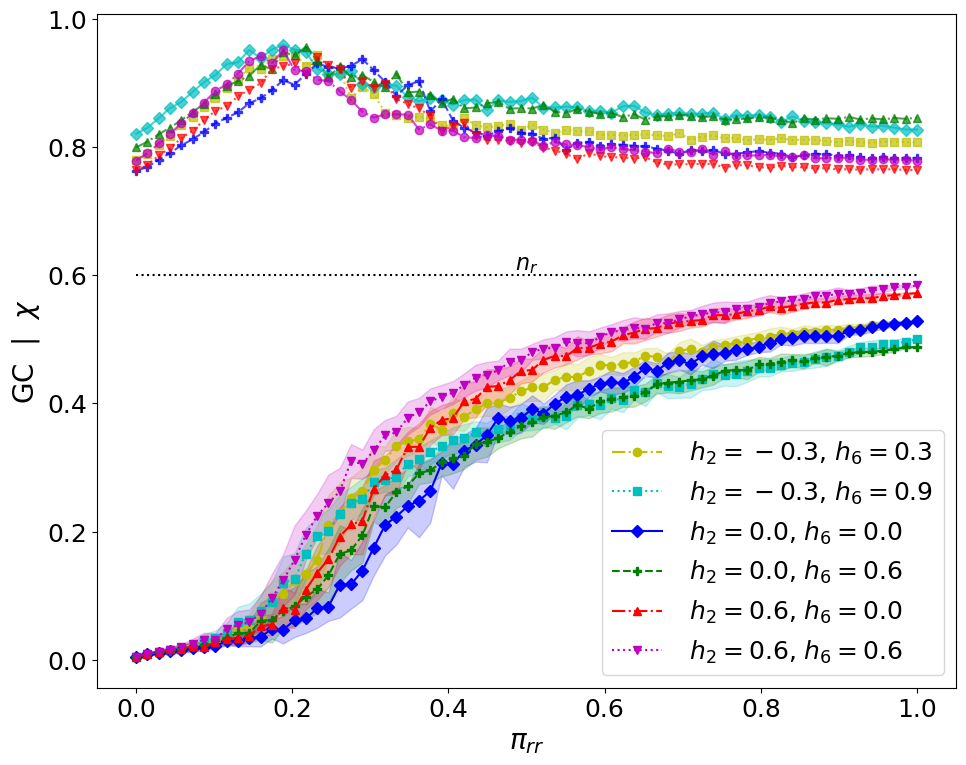

Figure saved as figs\recreated_color_percolation_2025-02-05_15-35-48.pdf


In [7]:
data_filename = os.path.join('data', 'color_percolation_data.pkl')

with open(data_filename, 'rb') as f:
    Data = pickle.load(f)

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Recreate the plot
N = 5*10**5
ave_degree = 6
Nr = int(.6*N)
combinations = [(-0.3, 0.3), (-0.3, 0.9), (0.0, 0.0), (0.0, 0.6), (0.6, 0.0), (0.6, 0.6)]
p_range = np.linspace(0, 1, 70)
p_rb, p_bb = 0, 0
Pi_range = [[p_rr, p_rb, p_bb] for p_rr in p_range]
ens = 20

# Initialize the plot with larger font sizes
plt.figure(figsize=(10, 8))
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

# Color and linestyle arrays
colors = ['y', 'c', 'b', 'g', 'r', 'm']  # Yellow, Cyan, Blue, Green, Red, Magenta
linestyles = ['-.', ':', '-', '--', '-.', ':']  # Dot-dash, Dotted, Solid, Dashed, Dot-dash, Dotted
markers = ['o', 's', 'D', 'P', '^', 'v']  # Circle, Square, Diamond, Plus, Triangle, Inverted Triangle

# Loop over each combination of data
for idx, (G, mean_gcc, std_gcc, mean_sus) in enumerate(Data):
    # Plot giant component size with unique color, linestyle, and marker
    plt.plot(p_range, mean_gcc, color=colors[idx], linestyle=linestyles[idx % len(linestyles)],
             marker=markers[idx % len(markers)], label=f' $h_2 ={combinations[idx][0]}$, $h_6={combinations[idx][1]}$')
    plt.fill_between(p_range, mean_gcc - std_gcc, mean_gcc + std_gcc, color=colors[idx], alpha=0.2)
    
    # Plot susceptibility with different marker and linestyle
    plt.plot(p_range, mean_sus, color=colors[idx], linestyle=linestyles[(idx + 1) % len(linestyles)],
             marker=markers[(idx + 1) % len(markers)], alpha=0.7)

# Add a horizontal line for Nr/N (fraction of red nodes)
plt.plot(p_range, [Nr/N for _ in p_range], color='k', linestyle=":")
plt.text((p_range[0] + p_range[-1]) / 2, Nr/N, '$n_r$', color='k', 
         ha='center', va='bottom', fontsize=16)

# Set labels and title
plt.xlabel('$\pi_{rr}$')
plt.ylabel('GC  |  '+'$\chi$')
plt.legend()
plt.tight_layout()

# Create figs directory if it does not exist
if not os.path.exists('figs'):
    os.makedirs('figs')

# Save the figure
fig_filename = os.path.join('figs', f'recreated_color_percolation_{timestamp}.pdf')
plt.savefig(fig_filename, bbox_inches='tight')
plt.show()

print(f"Figure saved as {fig_filename}")

## With $\pi_{rb} >0$ and  $\pi_{bb} >0$ 

<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:52: SyntaxWarning: invalid escape sequence '\p'
<>:53: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:52: SyntaxWarning: invalid escape sequence '\p'
<>:53: SyntaxWarning: invalid escape sequence '\c'
C:\Users\StegehuisC\AppData\Local\Temp\ipykernel_67716\1966964090.py:39: SyntaxWarning: invalid escape sequence '\p'
  marker=markers[idx % len(markers)], label=f'$\pi_{{rb}}$={p_rb}, $\pi_{{bb}}$={p_bb}')
C:\Users\StegehuisC\AppData\Local\Temp\ipykernel_67716\1966964090.py:39: SyntaxWarning: invalid escape sequence '\p'
  marker=markers[idx % len(markers)], label=f'$\pi_{{rb}}$={p_rb}, $\pi_{{bb}}$={p_bb}')
C:\Users\StegehuisC\AppData\Local\Temp\ipykernel_67716\1966964090.py:52: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('$\pi_{rr}$')
C:\Users\StegehuisC\AppData\Local\Te

2025-02-05_15-36-00
Total Homophily:  0.6
Total Homophily:  0.6
Total Homophily:  0.6
Total Homophily:  0.6


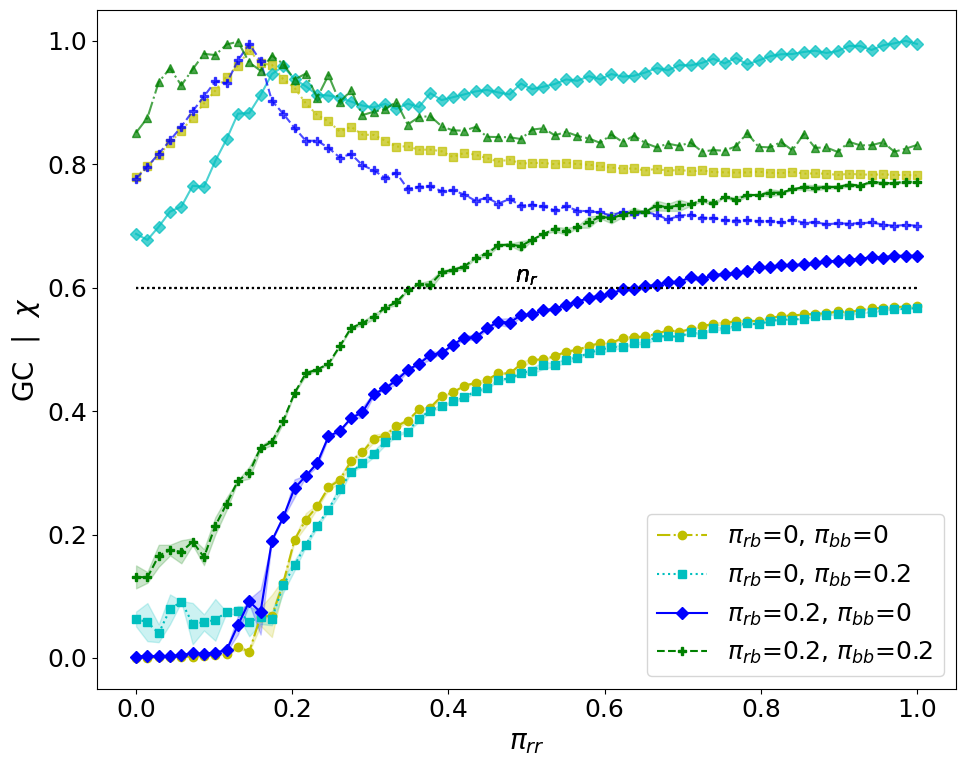

done 2025-02-05_15-36-30


In [8]:
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print(timestamp)

N = 5*10**3
ave_degree = 6
Nr = int(.6*N)
combinations = [(0.6, 0.6)]
p_range = np.linspace(0, 1, 70)
ens = 2

# Initialize the plot with larger font sizes
plt.figure(figsize=(10, 8))
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

# Color and linestyle arrays
colors = ['y', 'c', 'b', 'g', 'r', 'm']  # Yellow, Cyan, Blue, Green, Red, Magenta
linestyles = ['-.', ':', '-', '--', '-.', ':']  # Dot-dash, Dotted, Solid, Dashed, Dot-dash, Dotted
markers = ['o', 's', 'D', 'P', '^', 'v']  # Circle, Square, Diamond, Plus, Triangle, Inverted Triangle

for idx, (p_rb, p_bb) in enumerate([(0, 0), (0, .2), (.2, 0), (.2, .2)]):
    Pi_range = [[p_rr, p_rb, p_bb] for p_rr in p_range]

    # Loop over each combination of c and h
    Data = []
    h2, h = 0.6, 0.6
    G = elgent_graphs(N, Nr, h2, h, ave_degree, alpha=alpha_star(c=6))
    mean_gcc, std_gcc = color_percolation(G, Pi_range, ens)
    mean_sus = sus(G, Pi_range, ens)
    
    Data.append([G, mean_gcc, std_gcc, mean_sus])
    
        # Plot giant component size with unique color, linestyle, and marker
    plt.plot(p_range, mean_gcc, color=colors[idx], linestyle=linestyles[idx % len(linestyles)],
                 marker=markers[idx % len(markers)], label=f'$\pi_{{rb}}$={p_rb}, $\pi_{{bb}}$={p_bb}')
    plt.fill_between(p_range, mean_gcc - std_gcc, mean_gcc + std_gcc, color=colors[idx], alpha=0.2)
        
        # Plot susceptibility with different marker and linestyle
    plt.plot(p_range, mean_sus, color=colors[idx], linestyle=linestyles[(idx + 1) % len(linestyles)],
                marker=markers[(idx + 1) % len(markers)], alpha=0.7)
    
    # Add a horizontal line for Nr/N (fraction of red nodes)
    plt.plot(p_range, [Nr/N for _ in p_range], color='k', linestyle=":")
    plt.text((p_range[0] + p_range[-1]) / 2, Nr/N, '$n_r$', color='k', 
             ha='center', va='bottom', fontsize=16)

# Set labels and title
plt.xlabel('$\pi_{rr}$')
plt.ylabel('GC  |  '+'$\chi$')
plt.legend()
plt.tight_layout()

# Create figs directory if it does not exist
if not os.path.exists('figs'):
    os.makedirs('figs')

# Create data directory if it does not exist
if not os.path.exists('data'):
    os.makedirs('data')

# Save the figure
fig_filename = os.path.join('figs', f'pis_percolation_{timestamp}.pdf')
plt.savefig(fig_filename, bbox_inches='tight')
plt.show()

# Save the data using pickle
data_filename = os.path.join('data', f'pis_percolation_data_{timestamp}.pkl')
with open(data_filename, 'wb') as f:
    pickle.dump(Data, f)

print('done', datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


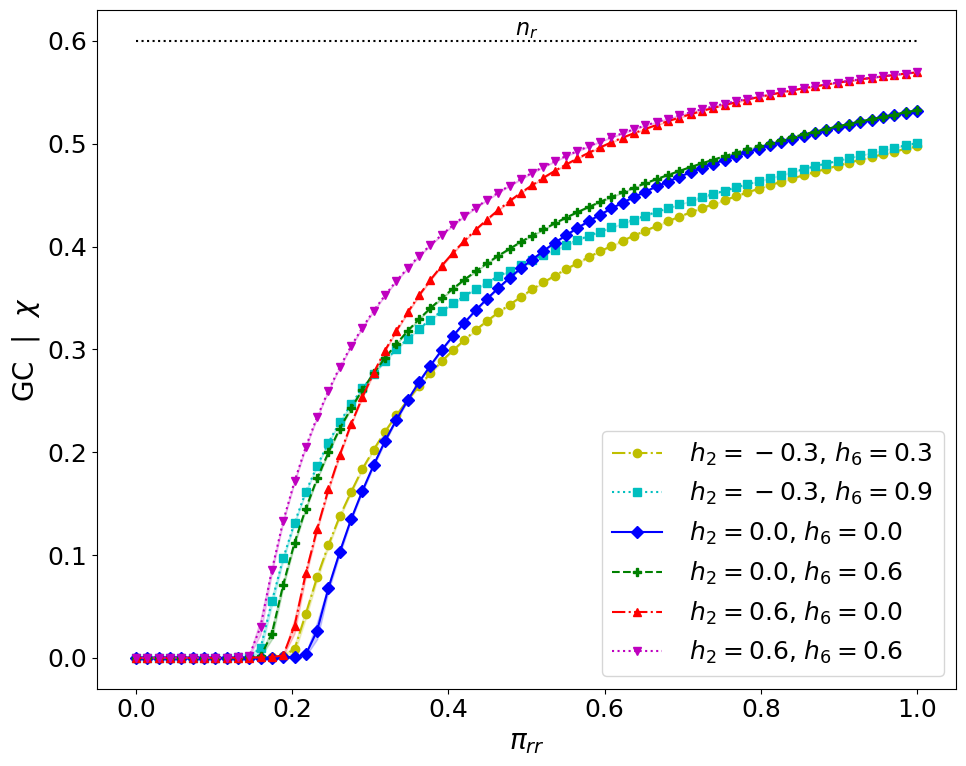

Figure saved as figs/recreated_color_percolation_2024-09-19_13-18-09.pdf


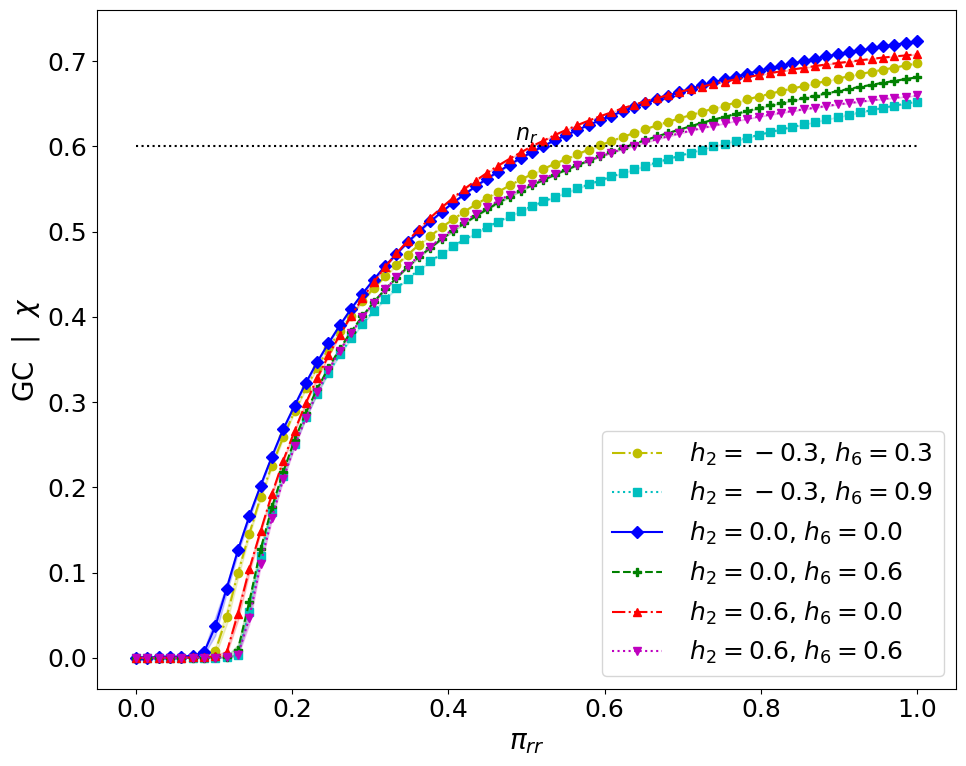

Figure saved as figs/recreated_color_percolation_2024-09-19_13-18-45.pdf


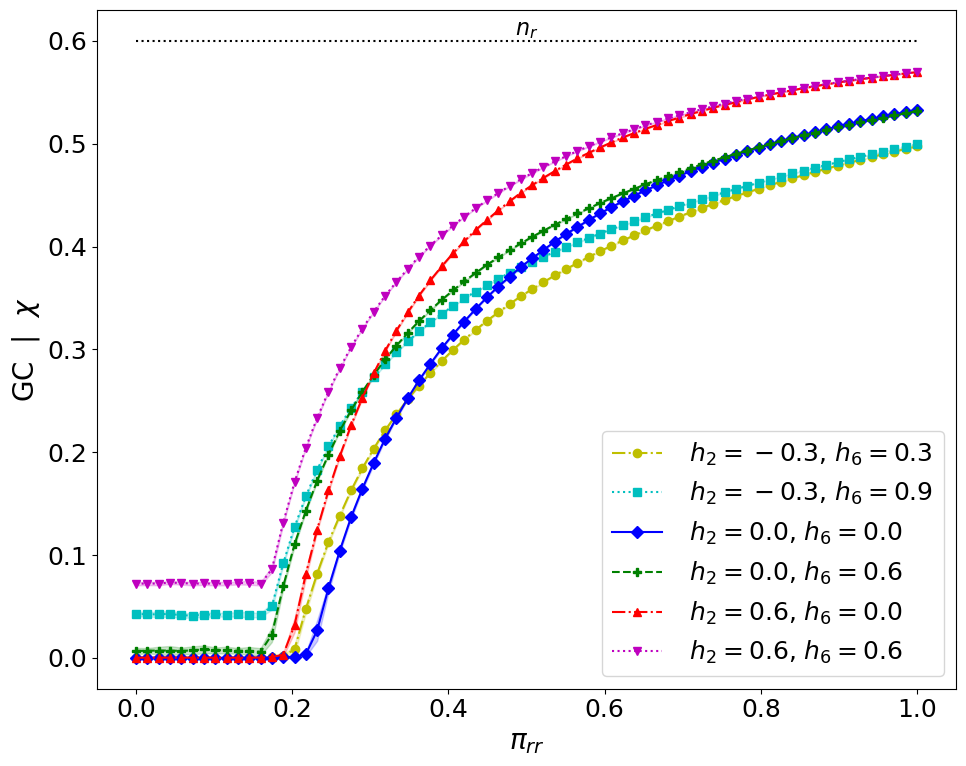

Figure saved as figs/recreated_color_percolation_2024-09-19_13-19-23.pdf


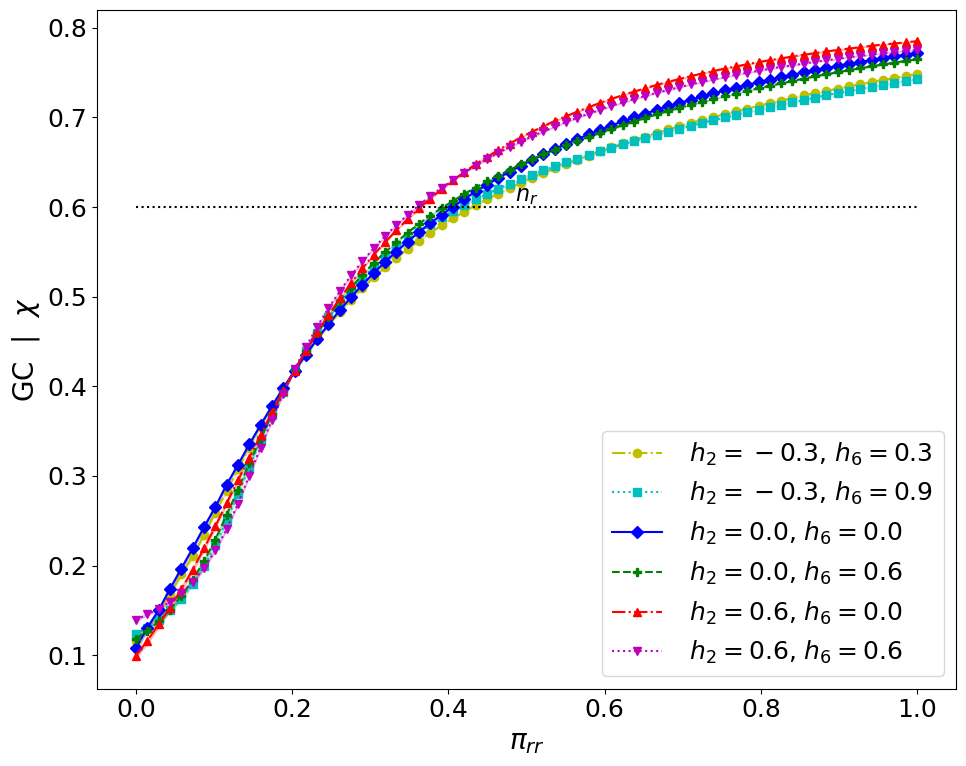

Figure saved as figs/recreated_color_percolation_2024-09-19_13-19-40.pdf


In [12]:
data_files = [
    os.path.join('data', 'color_percolation_data.pkl'),
    os.path.join('data', 'p_rb=0.2_percolation_data_2024-09-17_16-44-16.pkl'),
    os.path.join('data', 'p_bb=0.2_percolation_data_2024-09-17_16-46-49.pkl'),
    os.path.join('data', 'p_rb=0.2_p_bb=0.2_percolation_data_2024-09-17_16-51-26.pkl')]

for data_filename in data_files:
    
    with open(data_filename, 'rb') as f:
        Data = pickle.load(f)
    
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    
    # Recreate the plot
    N = 5*10**5
    ave_degree = 6
    Nr = int(.6*N)
    combinations = [(-0.3, 0.3), (-0.3, 0.9), (0.0, 0.0), (0.0, 0.6), (0.6, 0.0), (0.6, 0.6)]
    p_range = np.linspace(0, 1, 70)
    p_rb, p_bb = 0, 0
    Pi_range = [[p_rr, p_rb, p_bb] for p_rr in p_range]
    ens = 20
    
    # Initialize the plot with larger font sizes
    plt.figure(figsize=(10, 8))
    plt.rc('font', size=18)          # controls default text sizes
    plt.rc('axes', titlesize=20)     # fontsize of the axes title
    plt.rc('axes', labelsize=20)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
    plt.rc('legend', fontsize=18)    # legend fontsize
    
    # Color and linestyle arrays
    colors = ['y', 'c', 'b', 'g', 'r', 'm']  # Yellow, Cyan, Blue, Green, Red, Magenta
    linestyles = ['-.', ':', '-', '--', '-.', ':']  # Dot-dash, Dotted, Solid, Dashed, Dot-dash, Dotted
    markers = ['o', 's', 'D', 'P', '^', 'v']  # Circle, Square, Diamond, Plus, Triangle, Inverted Triangle
    
    # Loop over each combination of data
    for idx, (G, mean_gcc, std_gcc, mean_sus) in enumerate(Data):
        # Plot giant component size with unique color, linestyle, and marker
        plt.plot(p_range, mean_gcc, color=colors[idx], linestyle=linestyles[idx % len(linestyles)],
                 marker=markers[idx % len(markers)], label=f' $h_2 ={combinations[idx][0]}$, $h_6={combinations[idx][1]}$')
        plt.fill_between(p_range, mean_gcc - std_gcc, mean_gcc + std_gcc, color=colors[idx], alpha=0.2)
        
        # Plot susceptibility with different marker and linestyle
        #plt.plot(p_range, mean_sus, color=colors[idx], linestyle=linestyles[(idx + 1) % len(linestyles)],
         #        marker=markers[(idx + 1) % len(markers)], alpha=0.7)
    
    # Add a horizontal line for Nr/N (fraction of red nodes)
    plt.plot(p_range, [Nr/N for _ in p_range], color='k', linestyle=":")
    plt.text((p_range[0] + p_range[-1]) / 2, Nr/N, '$n_r$', color='k', 
             ha='center', va='bottom', fontsize=16)
    
    # Set labels and title
    plt.xlabel('$\pi_{rr}$')
    plt.ylabel('GC  |  '+'$\chi$')
    plt.legend()
    plt.tight_layout()
    
    # Create figs directory if it does not exist
    if not os.path.exists('figs'):
        os.makedirs('figs')
    
    # Save the figure
    fig_filename = os.path.join('figs', f'recreated_color_percolation_{timestamp}.pdf')
    #plt.savefig(fig_filename, bbox_inches='tight')
    plt.show()
    
    print(f"Figure saved as {fig_filename}")

<>:69: SyntaxWarning: invalid escape sequence '\p'
<>:69: SyntaxWarning: invalid escape sequence '\p'
<>:76: SyntaxWarning: invalid escape sequence '\p'
<>:69: SyntaxWarning: invalid escape sequence '\p'
<>:69: SyntaxWarning: invalid escape sequence '\p'
<>:76: SyntaxWarning: invalid escape sequence '\p'
C:\Users\StegehuisC\AppData\Local\Temp\ipykernel_67716\3369377784.py:69: SyntaxWarning: invalid escape sequence '\p'
  axs[i].text(0.1, 0.9, f"$\pi_{{br}}={pi_br}$ \n $\pi_{{bb}}={pi_bb}$", fontsize=18, ha='left', va='top', transform=axs[i].transAxes)
C:\Users\StegehuisC\AppData\Local\Temp\ipykernel_67716\3369377784.py:69: SyntaxWarning: invalid escape sequence '\p'
  axs[i].text(0.1, 0.9, f"$\pi_{{br}}={pi_br}$ \n $\pi_{{bb}}={pi_bb}$", fontsize=18, ha='left', va='top', transform=axs[i].transAxes)
C:\Users\StegehuisC\AppData\Local\Temp\ipykernel_67716\3369377784.py:76: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$\pi_{rr}$', fontsize=22)


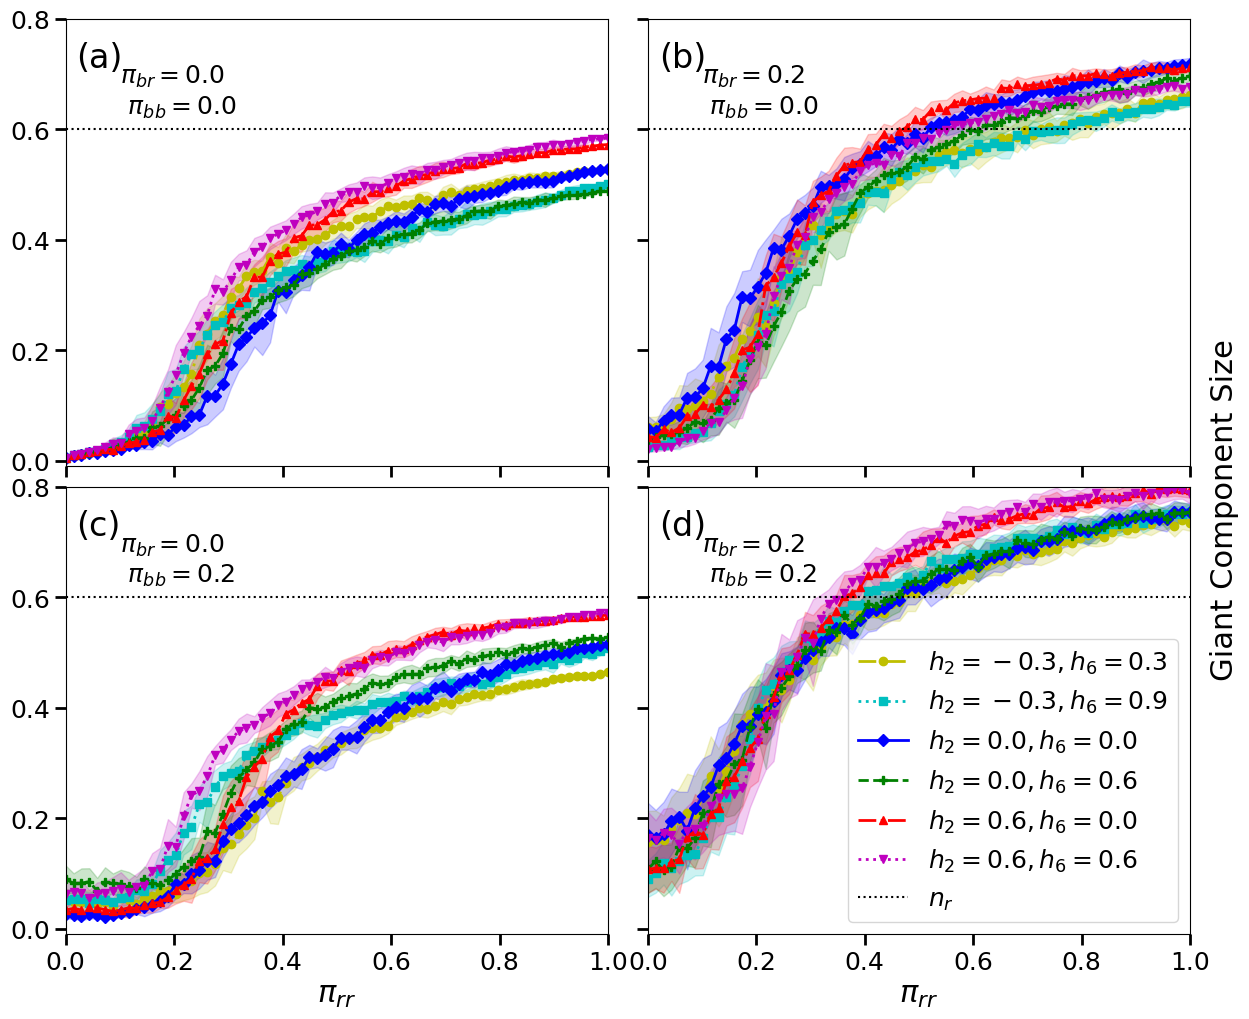

Figure saved as figs\percolation_4_panels_20250205_154151.pdf


In [13]:
# Function to load percolation data from .pkl files
def load_data(filenames):
    data_list = []
    for filename in filenames:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
            data_list.append(data)
    return data_list


# Define file paths
data_files = [
    os.path.join('data', 'color_percolation_data.pkl'),
    os.path.join('data', 'prb=0.2_pbb=0_color_percolation_data.pkl'),
    os.path.join('data', 'prb=0_pbb=0.2_color_percolation_data.pkl'),
    os.path.join('data', 'prb=0.2_pbb=0.2_color_percolation_data.pkl')
]

# Load all data
all_data = load_data(data_files)

# Extract p_rb and p_bb from filenames for title annotations
params = [(0.0, 0.0), (0.2, 0.0), (0.0, 0.2), (0.2, 0.2)]

# Example data variables
N = 5 * 10**5
ave_degree = 6
Nr = int(0.6 * N)
combinations = [(-0.3, 0.3), (-0.3, 0.9), (0.0, 0.0), (0.0, 0.6), (0.6, 0.0), (0.6, 0.6)]
p_range = np.linspace(0, 1, 70)
ens = 20

# Same line styles, colors, and markers as in original code
colors = ['y', 'c', 'b', 'g', 'r', 'm']  # Yellow, Cyan, Blue, Green, Red, Magenta
linestyles = ['-.', ':', '-', '--', '-.', ':']  # Dot-dash, Dotted, Solid, Dashed, Dot-dash, Dotted
markers = ['o', 's', 'D', 'P', '^', 'v']  # Circle, Square, Diamond, Plus, Triangle, Inverted Triangle

# Function to plot the 4-panel percolation results with the extracted values
def plot_percolation_4_panels(p_range, data_list, params, combinations, Nr, N):
    # Use sharex and sharey to link x- and y-axes across rows and columns
    fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex='col', sharey='row')  # 4 panels (2x2 grid)
    axs = axs.flatten()  # Flatten to 1D array for easier iteration

    # Set global font and style settings
    plt.rc('font', size=22)         # controls default text sizes
    plt.rc('axes', titlesize=24)    # fontsize of the axes title
    plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=20)   # fontsize of the tick labels
    plt.rc('ytick', labelsize=20)   # fontsize of the tick labels
    plt.rc('legend', fontsize=18)   # legend fontsize

    # Loop over the 4 panels and data
    for i, (data, ax) in enumerate(zip(data_list, axs)):
        # Each dataset contains: G, mean_gcc, std_gcc, mean_sus
        for idx, (G, mean_gcc, std_gcc, mean_sus) in enumerate(data):
            # Plot the giant component size with error bands for different homophily values
            ax.plot(p_range, mean_gcc, label=f'$h_2={combinations[idx][0]}, h_6={combinations[idx][1]}$', 
                    color=colors[idx], linestyle=linestyles[idx % len(linestyles)], 
                    marker=markers[idx % len(markers)], linewidth=2)
            ax.fill_between(p_range, mean_gcc - std_gcc, mean_gcc + std_gcc, 
                            color=colors[idx], alpha=0.2)

        # Extract p_rb and p_bb from params for panel title
        pi_rb, pi_bb = params[i]
        pi_br = pi_rb
        axs[i].text(0.02, .95, f"({chr(97 + i)})", fontsize=24, ha='left', va='top', transform=axs[i].transAxes)

        # Add title with $\pi_br$ and $\pi_bb$ inside the panel
        axs[i].text(0.1, 0.9, f"$\pi_{{br}}={pi_br}$ \n $\pi_{{bb}}={pi_bb}$", fontsize=18, ha='left', va='top', transform=axs[i].transAxes)

        # Add title with p_rb and p_bb in the panel
        #ax.set_title(f"$\pi_{{rb}}={pi_rb}$, $\pi_{{bb}}={pi_bb}$")

        # Set axis labels only for the bottom row (shared x-axis)
        if i >= 2:  # Only set x-axis labels for the last row
            ax.set_xlabel('$\pi_{rr}$', fontsize=22)

        # Set limits for x and y axes
        ax.set_xlim(0, 1)
        ax.set_ylim(-0.01, 0.8)

        # Plot the horizontal line for $n_r$
        ax.axhline(Nr / N, color='k', linestyle=":", label='$n_r$')

        # Improve tick marks
        ax.tick_params(axis='both', which='major', length=8, width=2)
        ax.tick_params(axis='both', which='minor', length=4, width=1.5)
 
    # Set the ylabel only on the left side (shared y-axis title)
    fig.text(1.0, 0.5, 'Giant Component Size', va='center', rotation='vertical', fontsize=22)

    # Add legend inside the last panel
    axs[-1].legend(loc='lower right')

    # Remove spacing between the subplots
    plt.subplots_adjust(wspace=0, hspace=0)
    

    plt.tight_layout(pad=0)

    # Save the figure
    if not os.path.exists('figs'):
        os.makedirs('figs')
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = os.path.join('figs', f'percolation_4_panels_{timestamp}.pdf')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

    print(f"Figure saved as {filename}")

# Call the function to plot the 4-panel figure
plot_percolation_4_panels(p_range, all_data, params, combinations, Nr, N)